In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [4]:
prefix = 'HS.'

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

if prefix == 'HIS.':
    geneset = HIS_gene 
elif prefix == 'HS.':
    geneset = HS_gene
else:
    geneset = geneset

# compare confusion matrix

In [4]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff 
    col_dict={'cadd15':('CADD_phred', 15), 'cadd18':('CADD_phred', 18),
              'cadd20':('CADD_phred', 20), 'cadd22':('CADD_phred', 22),
              'cadd24':('CADD_phred', 24), 'cadd26':('CADD_phred', 26),
              'cadd28':('CADD_phred', 28), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10),
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122),
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642),
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56),
              'revel_0.4':('REVEL',0.4),'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9),
              'mpc_1':('MPC',1),'mpc_1':('MPC',2)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)# y_true <=target(true label)= 1 or 0 , y_pred = 1 or 0 depends on method and threshold
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../ccfigure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    values = values[~np.isnan(values)] # remove NA
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

# validation = '../data/output/output_data_mode5.cnn.csv'# validation is 20% of DNM not used in training and testing
# fname = validation
# df = pd.read_csv(fname)
# df = df[df.training==0]
# y_true = df.pop('target')
# dataset = 'validation(20% HGMD,DiscovEHR)'
# #plot_multi_confusion_matrix(df, y_true, dataset, save=True)

In [ ]:
'''


#fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv', # teacher7's old score using wrong GC
#          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv', # cc's brand new score using correct GC
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


'''

# ROC

In [16]:
## cc's new function for roc curve 

def plot_roc(df, y_true, label):
    
    #### change color for curves ## tried but failed
    #num_plots = 13

    ## Have a look at the colormaps here and decide which one you'd like:
    ## http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    #colormap = plt.cm.gist_ncar
    #plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    
    cpool = [ '#000000', '#bbb12d', '#1480fa', '#bd2309',
              '#2edfea', '#ea2ec4', '#ea2e40', 'gold',#'lightgreen',#'#cdcdcd',
              '#577a4d',  '#f59422', '#2e46c0','#219774', 'purple']#'#8086d9' ]
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore','REVEL', 'MPC']
    
    color_dict = {'cnn_prob':cpool[0], 'MetaSVM_rankscore':cpool[1], 'MetaLR_rankscore':cpool[2],
              'M-CAP_rankscore':cpool[3], 'DANN_rankscore':cpool[4],'CADD_phred':cpool[5],
              'Eigen-phred':cpool[6],'Polyphen2_HVAR_rankscore':cpool[7], 
              'MutationTaster_converted_rankscore':cpool[8],
              'FATHMM_converted_rankscore':cpool[9], 
              'fathmm-MKL_coding_rankscore':cpool[10],
              'REVEL':cpool[11], 
              'MPC':cpool[12]}
        
    for algo in algos:
        index = (df[algo].notnull()) & (df[algo]!= -1) & (df[algo]!= 0) 
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for idx, algo in enumerate(algos):
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]),
                 color =color_dict[algo])

        plt.plot([0, 1], [0, 1], color='Navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('Receiver operating characteristic of {}: {} positive, {} negative'.format(label, pos, neg))
    plt.legend(loc="lower right", fontsize = 'medium')
    #plt.show()
    #plt.savefig('../ROC_figure/ROC_'+label+'_dpi600.eps', format='eps', dpi=1200)
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

In [17]:
# ignore validaiton part
# class_names = ['damage_negative', 'damage_positive']
# fname = validation
# df = pd.read_csv(fname)
# y_true = df.pop('target')
#plot_roc(df, y_true, label = 'validation')
#Find_Optimal_Cutoff(y_true, df['cnn_prob'])

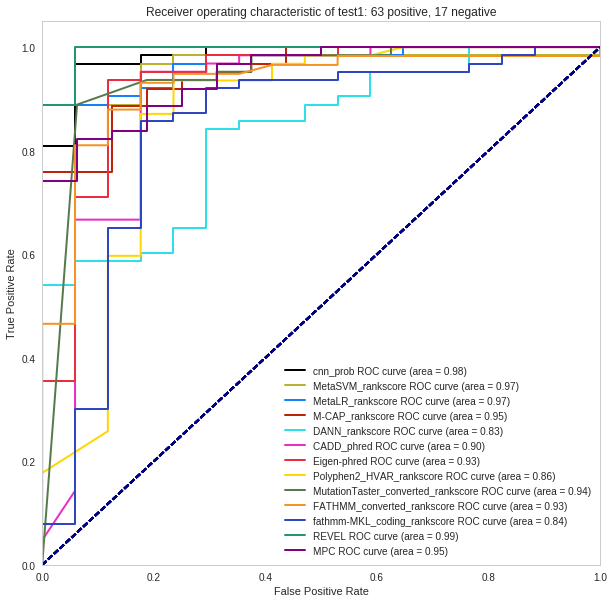

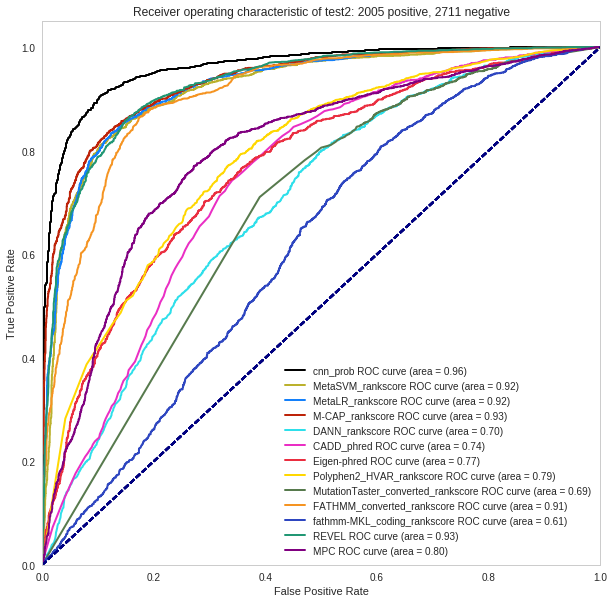

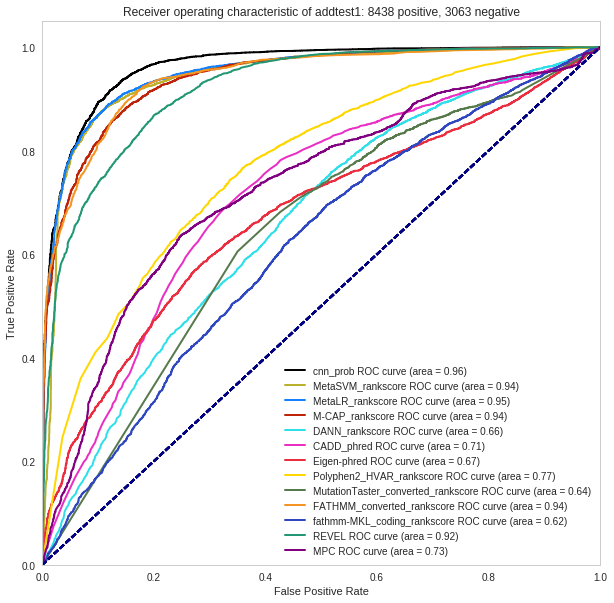

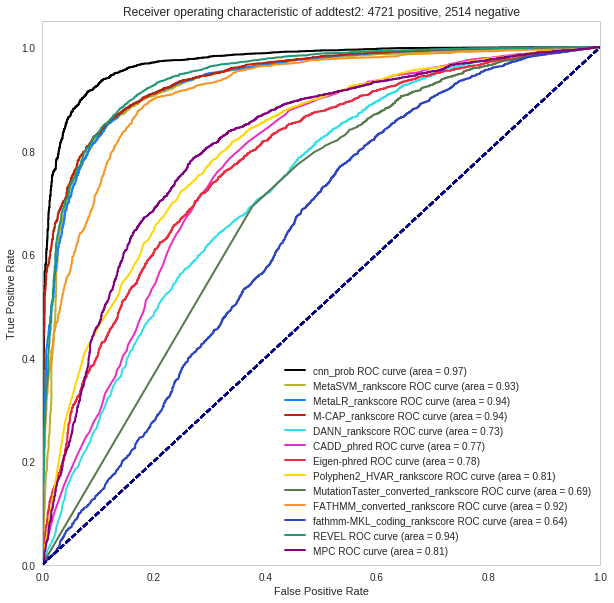

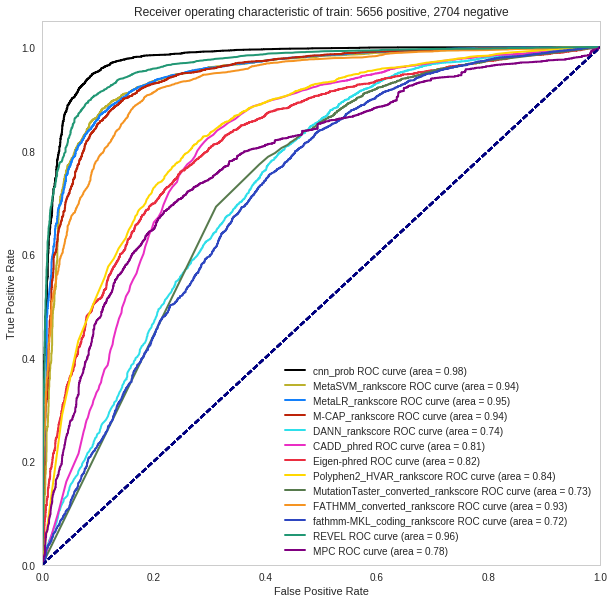

In [20]:
# metaSVM test
#fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv', # teacher7's old score using wrong GC
#          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
#          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv', # cc's brand new score using correct GC
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.GCcorrected.cnn.csv']

labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, label in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, label)
    plt.savefig('../ROC_figure/ROC_'+prefix+'_'+label+'_dpi600.eps', format='eps', dpi=1200)
    #plt.savefig('methcomp+revel_'+fname.split('_')[-1].split('.')[0]+".eps", bbox_inches='tight') file not found!

# test among clivar/UniFun from papers

In [ ]:
'''
# metaSVM test
fnames = ['../data/paper_test/ClinVar.anno.rare.' + prefix + 'reformat.cnn.csv', 
          '../data/paper_test/UniFun.anno.rare.' + prefix + 'reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, label in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, label)
    #plt.savefig('methcomp+revel_'+fname.split('_')[-1].split('.')[0]+".png", bbox_inches='tight') file not found!
'''

# cancer hotspot among oncogene / TS genes

In [21]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer_sel.HIS.reformat.GCcorected.cnn.csv' # teacher7 old wrong GC
#fname = '../data/cancer_hotspots/cancer_sel.HIS.reformat.GCcorrected.cnn.csv'
cancer_HIS = pd.read_csv(fname)
#fname = '../data/cancer_hotspots/cancer_sel.HS.reformat.cnn.csv' # teacher7 old wrong GC
fname = '../data/cancer_hotspots/cancer_sel.HS.reformat.GCcorrected.cnn.csv'
cancer_HS = pd.read_csv(fname)
cancer= pd.concat([cancer_HIS, cancer_HS], ignore_index=True)

with open('../data/gene/oncogenes.txt') as f:
    onco = set(line.strip() for line in f.readlines())

with open('../data/gene/tumor_sup.txt') as f:
    tumor_sup = set(line.strip() for line in f.readlines())

cancer_genesets = [HIS_gene, tumor_sup, HIS_gene & tumor_sup, onco, HS_gene]
cancer_genesets_label = ['HIS_gene', 'tumor_sup', 'HIS_gene & tumor_sup', 'onco', 'HS_gene']
for idx, cancer_geneset in enumerate(cancer_genesets):
    print len(cancer_geneset)
    index =  cancer['genename'].isin(cancer_geneset) 
    tmp = cancer[index]
    y_true = tmp.target
    plot_roc(tmp, y_true, label = 'cancer ' + cancer_genesets_label[idx])
    plt.savefig('../ROC_figure/ROC_cancer'+cancer_genesets_label[idx]+'_dpi600.eps', format='eps', dpi=1200)
    #plt.savefig('methcomp+revel_'+'cancer'+cancer_genesets_label[idx], bbox_inches='tight')

IOError: File ../data/cancer_hotspots/cancer_sel.HIS.reformat.GCcorected.cnn.csv does not exist

# enrichment

In [140]:
fname = '../data/gene/mis_rate_hongjian_one_gene0617.txt'
mutation_bkgrd = MutationBackground(fname)

def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd18':('CADD_phred', 18),
              'cadd20':('CADD_phred', 20), 'cadd22':('CADD_phred', 22),
              'cadd24':('CADD_phred', 24), 'cadd26':('CADD_phred', 26),
              'cadd28':('CADD_phred', 28), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56),
              'revel_0.4':('REVEL',0.4),'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9)}
    
    col_dict={'cadd15':('CADD_phred', 15), 
              'cadd20':('CADD_phred', 20), 
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              #'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              #'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56), 
              'MPC>1':('MPC', 1), 'MPC>2':('MPC', 2),
              'revel_0.4':('REVEL',0.4),'revel_0.5':('REVEL',0.5),
              'revel_0.6':('REVEL',0.6),'revel_0.7':('REVEL',0.7),'revel_0.8':('REVEL',0.8),
              'revel_0.9':('REVEL',0.9)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        
        #adjust the baseline mutation rate difference in cases vs controls
        control_count = control_count*syn_ratio[case_disease[0]]
        
        total_counts = case_count + control_count
        control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size)) ##??
        risk_gene = case_count * (enrich - 1) / enrich
        enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size
        if exp == 0: # use control instead
            exp = case_count - risk_gene
            
        exp_enr = case_count / exp
        exp_risk_gene = case_count * (exp_enr - 1) / exp_enr
        exp_tpr = (exp_enr - 1) / exp_enr
        
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    #plot_rate_vs_riskvariants(df, title=','.join(case_disease), vs_bkg=False)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease), vs_bkg=True)
    return df

def plot_rate_vs_riskvariants(df, title,  vs_bkg):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    
    if vs_bkg:
        x = list(df['exp_tpr'])
        y = list(df['exp_risk_gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        elif 'MPC' in txt:
            color = 'green'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    if vs_bkg:
        fname = '../enrich_figure/'+prefix+title+'vsbkg.eps'
        title = 'Case VS background\n{}: {} variants in cases'.format(title, 
                                            case_variants)
    else:
        fname = '../enrich_figure/'+prefix+title+'vscontrol.eps'
        title = 'Case VS control\n{}: {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants)
    
    ax.set_title(title, fontsize=15)
    #fig.savefig(fname)
    fig.savefig(fname, format='eps', dpi=1000)

In [141]:
disease_size = {'CHD':2779, 'CDH':307,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789,
                'ID_DDD_EE':5620,
                'control':2078} 

#fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
#control_disease = ['SSC_yale']
#
#fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
#control_disease = ['SSC']
#syn_ratio = {'CHD_yale':1.03504,'ASD':1.02691,'DDD_new':0.99904,'ID_DDD_EE':1.13627} # vs 1911control

fname = '../data/case_control/control_MarkDaly.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
control_disease = ['control']
syn_ratio = {'CHD_yale':1.03743,'ASD':1.02928,'DDD_new':1.001342,'ID_DDD_EE':1.13889} # vs MDcontrol
#syn_variant_num = {'CHD_yale':727 ??? qihongijan please check,'ASD':1026,'DDD_new':1084,'control':524} # vs MDcontrol


df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
#case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
#                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [ ['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
case_disease = ['DDD_new']
#print syn_ratio[case_disease[0]]

df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/case_MarkDaly.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
case_disease = ['ID_DDD_EE']
df_case = pd.read_csv(fname)
index = df_case['genename'].isin(geneset)    
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.GCcorected.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)    

# this is the comparison between controls
# fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csvAnn.mpc.csv'
# case_disease = ['SSC_yale']
# df_case = pd.read_csv(fname)
# index =  df_case['genename'].isin(geneset) 
# df_case = df_case[index]
# case_info = (df_case, case_disease, disease_size)
# df = display_enrichment(case_info, control_info, case_disease, geneset)

IOError: File ../data/case_control/control_MarkDaly.anno.rare.HS.reformat.GCcorected.cnn.csv does not exist

# case control enrichment line

In [ ]:
import bisect

def display_enrichment2(case_info, control_info, case_disease):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    cols = ['CADD_phred', 'cnn_prob', 'MPC', 'REVEL']
    tpr, riskg = [], []
    for col in cols:
        tpr_lst, riskg_lst = get_enr_line(df_case, case_size, df_control, control_size, col)
        tpr.append(tpr_lst)
        riskg.append(riskg_lst)
        
    title = ''
    plot_rate_vs_riskvariants2(cols, tpr, riskg, title)

def get_enr_line(df_case, case_size, df_control, control_size, col):
    tpr_lst, riskg_lst = [], []
    
    index = (df_case[col].notnull()) & (df_case[col]!= -1) & (df_case[col]!= 0)
    case_scores = sorted(df_case.ix[index][col].values)
    case_total = len(case_scores)
    
    index = (df_control[col].notnull()) & (df_control[col]!= -1) & (df_control[col]!= 0)
    control_scores = sorted(df_control.ix[index][col].values)
    control_total = len(control_scores)
    
    threshold = np.unique(case_scores + control_scores)
    for thres in threshold:
        case_count = case_total - bisect.bisect_right(case_scores, thres)
        control_count = control_total - bisect.bisect_right(control_scores, thres)
        
        
        if control_count != 0:
            
            enrich = float(case_count) / case_size / (float(control_count) / control_size)
            if enrich > 1:
                tpr = (enrich - 1) / enrich
                risk_gene = case_count * tpr
                tpr_lst.append(tpr)
                riskg_lst.append(risk_gene)
    return tpr_lst, riskg_lst 
    
def plot_rate_vs_riskvariants2(cols, tpr, riskg, title):

    fig, ax = plt.subplots(figsize = (15,10))
    for c, t, r in zip(cols, tpr, riskg):
        ax.plot(t, r, label=c)
    ax.legend()

In [ ]:
case_diseases = [ ['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csvAnn.mpc.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment2(case_info, control_info, case_disease)


fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csvAnn.mpc.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)

fname = '../data/case_control/case_MarkDaly.anno.rare.'+prefix+'reformat.cnn.csvAnn.mpc.csv'
case_disease = ['ID_DDD_EE']
df_case = pd.read_csv(fname)
index = df_case['genename'].isin(geneset)    
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)

fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csvAnn.mpc.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment2(case_info, control_info, case_disease)    